<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

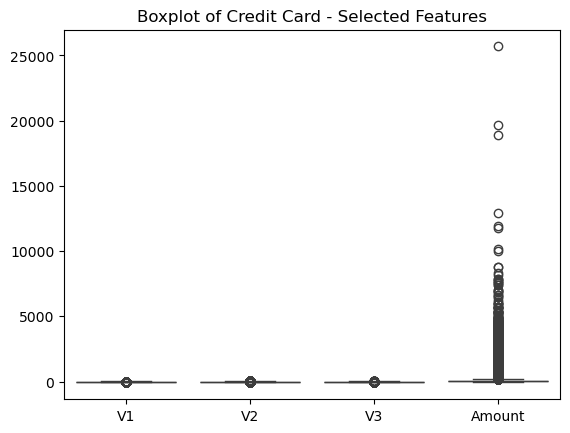

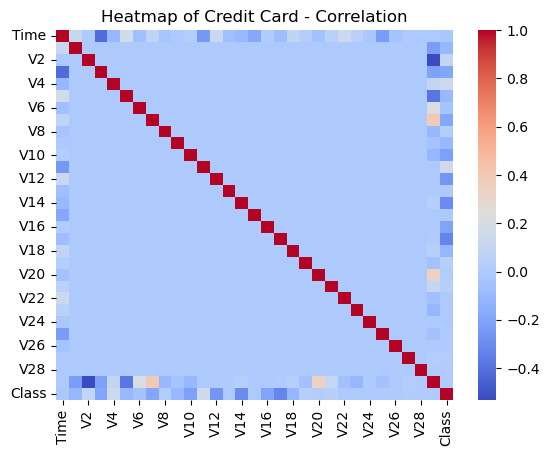

StandardScaler()
anomaly
 1    56859
-1      103
Name: count, dtype: int64
Train labels:
 Class
0    227451
1       394
Name: count, dtype: int64
Test labels:
 Class
0    56864
1       98
Name: count, dtype: int64
Baseline evaluation
[[56797    67]
 [   68    30]]
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     56864
     anomaly       0.31      0.31      0.31        98

    accuracy                           1.00     56962
   macro avg       0.65      0.65      0.65     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score: 0.9976299989466662
Model saved successfully


In [1]:
#We will continue to utilize the ETL pipeline and our ML pipeline(We built for CloudWatch Sentinel) this in order to build our pipeline for the FraudSniper
import csv
import pandas as pd
import numpy as np

#Import Modules In Order to Get our Box-Plot
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

#This helps us have training data and testing data
from sklearn.model_selection import train_test_split

#We must import our Isolation Tree Model 
from sklearn.ensemble import IsolationForest

#This helps us import our StandardScaler modules to scale our numeric features
from sklearn.preprocessing import StandardScaler

#Import the classification report and confusion matrix model so we can check our model before
# and after we tune the data in our dataset
from sklearn.metrics import classification_report, confusion_matrix

# Import modules for getting an accuracy score
from sklearn.metrics import accuracy_score

#Import the module to save this to a pipeline
import joblib

#Help us read our data from our CSV file containing all relevant data for our credit card fraud detection
df = pd.read_csv("creditcard.csv")

# head() - displays the entire data table 
#df.head())

#info() function - Displays the data as a DataFrame, gives us Range Index for data entires, tells us total columns
# and what each column datatyoe and null values are (non-null value), and the memory usuage of thethe data
df.info()

#describe function - desceibes what each value in our data means such as the count, mean, std, min, max
df.describe()

#isnull().sum() = Check for any null values in our data 
df.isnull().sum()

#.nunique() - This function tells us the unique(distinct) amount of data values that are found in each one of our columns 
# of our DataFrame 
df.nunique() 


# Clean the data given to us in our CSV file(Examples Has Duplicates, Outliers, Fixing Errors, Convert Data Values, eliminate

#1. Checks to see if there are any duplicates Remove Duplicates - Gives us the sum of our 
print("Number of Duplicates in our Data: ", df.duplicated().sum())


#2. Displaying Any Outliers in Our Data

#We can check out any out outliers with a box plot collecting the data
#in the csv file

#For our box plot and our Heatmap, we need a subset of value
sns.boxplot(data = df[['V1','V2','V3','Amount']])
plt.title('Boxplot of Credit Card - Selected Features')
plt.show()

#We can also create graphs such as histograms and heatmaps(Numeric features)

#This is our heatmap for our data

#We need correlation for our heatmap, not raw values
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Heatmap of Credit Card - Correlation')
plt.show()


# We must scale our numeric features
scaler = StandardScaler()

#We can can fit our data from data - this shows 
print(scaler.fit(df))


#We can get the mean now and transform data with Standard Scaler
#print(scaler.mean_)

#print(scaler.transform(df))

#We can fit and transform our data

#We can drop the Class label since we already have numeric values for it or scale the label
#Applies standard scaling via z-score(z = x - u/sigma)
scaled = scaler.fit_transform(df.drop(columns=['Class']))

#Converts our Numpy array into a DataFrame and adds the features name back to our scaled DataFrame
df_scaled = pd.DataFrame(scaled, columns=df.drop(columns=['Class']).columns) 


#We can also use one time encoding in order encode all of our categorical data
pd.get_dummies(df, sparse=True)

#We can also filter an anomaly_score to be of the value 0/1 and the actual anomaly to be 1 since this is the code for it
#df['anomaly_score'] = 0/1

#df['anomaly'] = 1

#Create a threshold o
#threshold = 0


#Now Im going to create my training data and testing data for my isolation tree model

#First we need to create our x and y variables for looking over class
X = df.drop('Class', axis=1).astype(float)

y = df['Class']

#We need to scale our X values and fit and transform that data
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=42,stratify=y)

#Now we need to create our Isolation Forest Algorithmn
#Fraud in the dataset is  < 0.2%
isolation_forest_algo = IsolationForest(n_estimators=200,contamination=0.0017,random_state=42)

#Create DataFrames for the X_train and X_test before fitting the data
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

#Now we are going to use our X training data
isolation_forest_algo.fit(X_train)

#Now we are going to calcualte our anomaly score with the predict fucntion and setting out threshold to the value we have for contamination

#Lets create our test data
X_test_data = df.loc[X_test.index].copy()

#This helps with creating our anomaly score since a higher score means more normal and a lower scores means more anomalous
X_test_data['anomaly_score'] = isolation_forest_algo.decision_function(X_test)

#This helps us assign values to helps us predict our score -1 for anomaly, 1 for normal
X_test_data['anomaly'] = isolation_forest_algo.predict(X_test)

#We must analyze our results for this model
print(X_test_data['anomaly'].value_counts())

#Now we can get our classification report and confusion matrix before we tune the data

#Lets create our own threshold using the 0.17%

scores = isolation_forest_algo.decision_function(X_test)

threshold = np.percentile(scores, 0.17)

#We need a y prediction value and we need to convert into an integer type
y_pred = (scores < threshold).astype(int)

print("Train labels:\n", y_train.value_counts())
print("Test labels:\n", y_test.value_counts())

print("Baseline evaluation")

#This is our confusion matrix before tuning the data
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

#This is our classsification report before tuning the data
print(classification_report(y_test, y_pred,target_names=["normal", "anomaly"],zero_division=0))

#Now we will get our accuracy score 
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy}')

#Now we need to save our model for deployment
joblib.dump(isolation_forest_algo, "fraud_detection.pkl")

model = joblib.load("fraud_detection.pkl")
print("Model saved successfully")